In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Knowledge Distillation
**Distillation learning** is a technique where a smaller, simpler model (called the student) is trained to mimic the behavior of a larger, more complex model (called the teacher). 
The goal is to **transfer the knowledge from the teacher model to the student model**, 
enabling the **student** to achieve **similar performance** while being **more efficient in terms of size, speed, and resource usage**.

## Kullback-Leibler divergence (KL divergence) 
* KL divergence is the divergence between the probability distributions predicted by the teacher model and the student model. 
* The teacher's logits are scaled by T\*T where T\*T is the temperature of the softmax function. 
* A higher temperature smooths the probability distributions, making them easier for the student to learn from.

## Knowledge Distillation Step-by-Step
1. **Train the Teacher**
Train a large, complex teacher model (like BERT) on your dataset using its standard loss function (e.g., cross-entropy loss for classification tasks).
2. **Generate Teacher Predictions**
Use the teacher model to generate predictions for your training data. These predictions will be used as a target for the student model.
3. **Train Student Model** 
Initialize a smaller student model (like DistilBERT). 
Define the loss function combining cross-entropy loss, knowledge distillation loss, and optionally, cosine similarity loss.
4. **Compute Losses** 
combine these losses into a single loss function for training the student model:
$$L_{\text{student}} = \alpha L_{\text{CE}} + (1 - \alpha) L_{\text{KD}}$$
5. **Train Student Model** 
Use the combined loss function to train the student model on your dataset.


**Note** More details regarding knowledge distillation can be found from the link provided below.
This notebook was also inspired by that given in this link https://github.com/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb.

* Here model compression is applied on roberta model

In [2]:
import shutil
dir_path = "/kaggle/working/"
# Delete the directory and all its contents
try:
    shutil.rmtree(dir_path)
    print(f"{dir_path} has been deleted.")
except Exception as e:
    print(f"Failed to delete {dir_path}. Reason: {e}")

Failed to delete /kaggle/working/. Reason: [Errno 16] Device or resource busy: '/kaggle/working/'


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load and Explore The Data

In [4]:
from datasets import load_dataset

clinc_ds = load_dataset("clinc_oos", "plus")
clinc_ds

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [5]:
# check number of classes in training data labels

intents = clinc_ds['train'].features['intent']
intents

ClassLabel(names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined', 'rewards_balance', 'change_accent', 'vaccines', 'reminder_update', 'food_last', 'change_ai_name', 'bill_due', 'who_do_you_work_for', 'share_location', 'international_visa', 'calendar', 'translate',

In [6]:
import random
# RANDOM_SEED = 42
# random.seed(RANDOM_SEED)

rand_idx = random.randint(0, len(clinc_ds['train']))
sample_example = clinc_ds['train'][rand_idx]

print(f'sample example: {sample_example}')
print(f'intent converted to str: {intents.int2str(sample_example["intent"])}')

sample example: {'text': 'how many swedish kroner do i get for a dollar', 'intent': 38}
intent converted to str: exchange_rate


In [7]:
rand_idx = random.randint(0, len(clinc_ds['test']))
sample_example_test = clinc_ds['test'][rand_idx]

print(f'sample example: {sample_example_test}')
print(f'intent converted to str: {intents.int2str(sample_example_test["intent"])}')

sample example: {'text': 'what kind of hobbies does the ai have', 'intent': 15}
intent converted to str: what_are_your_hobbies


# Transformer Classification Pipeline

## Make predictions with Transformer pipeline

In [8]:
import transformers
from transformers import pipeline

# baseline_model_ckpt = 'optimum/roberta-large-finetuned-clinc'
# baseline_model_ckpt = 'transformersbook/bert-base-uncased-finetuned-clinc'
baseline_model_ckpt = 'optimum/roberta-large-finetuned-clinc'
baseline_model_name = 'roberta-large-finetuned-clinc'
pipe = pipeline('text-classification', baseline_model_ckpt, device=device)
pipe_out = pipe(sample_example['text'])
pipe_out

2024-08-20 14:06:50.052632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 14:06:50.052751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 14:06:50.179099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/8.33k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

[{'label': 'exchange_rate', 'score': 0.9924822449684143}]

In [9]:
pipe_out = pipe(sample_example_test['text'])
pipe_out

[{'label': 'what_are_your_hobbies', 'score': 0.9923701286315918}]

In [10]:
# check current working directory 

import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /kaggle/working


# Install evaluate

* **evaluate** offers a wide range of **pre-built evaluation metrics commonly used in NLP**, including accuracy, F1 score, BLEU, ROUGE, and more.

In [11]:
# try:
#     import evaluate
#     print("evaluate is already installed.")
# except ImportError:
#     !pip install evaluate
#     import evaluate
#     print("evaluate has been installed and imported.")

# Performance Benchmark Class (To evaluate transformer models)

**Accuracy**: Measures how often the model’s predictions match the true labels

**Model Size**: Refers to disk space the model occupies

**Latency**: Represents the duration required for the model to process inputs or complete tasks

In [12]:
BATCH_SIZE = 48

In [13]:
import torch
import transformers
from transformers import pipeline
import datasets
from datasets import load_metric
# import evaluate

accuracy_score = load_metric('accuracy', trust_remote_code=True)

from tqdm import tqdm

import numpy as np

from pathlib import Path
import time


class PerformanceBenchmark:
    
    def __init__(self, 
                 pipeline: transformers.pipeline, 
                 dataset: datasets.Dataset,
                 model_name: str = 'model.pt') -> None: 
        
        self.model_name = model_name
        self.pipeline = pipeline
        self.dataset = dataset
        
    def compute_size(self) -> dict:
        """
        Computes size of pipeline model.
        """
        model_state_dict = self.pipeline.model.state_dict() # get model's state_dict (all parameters)
        tmp_path = Path(self.model_name)
        torch.save(model_state_dict, tmp_path) # temporarily save the model
        
        model_size = np.round(Path(tmp_path).stat().st_size / (1024 * 1024), 2) # get size of model in MBs
        
        tmp_path.unlink() # deletes the temporarily save model
        
        print(f'Size of Model {self.model_name}: {model_size} MB')
        
        return {'model_size_MBs': model_size}
    
    def compute_accuracy(self) -> dict:
        """
        Computes accuracy score.
        """
        # Collect all texts in a list for batch processing
        texts = [sample['text'] for sample in tqdm(self.dataset, desc="Processing texts")]
        predictions = []
        predictions = self.pipeline(texts)

        preds, labels = [], []
        for prediction, sample in tqdm(zip(predictions, self.dataset), desc="getting preds and labels"):
            pred_label = intents.str2int(prediction['label'])
            true_label = sample['intent']
            preds.append(pred_label)
            labels.append(true_label)
            
#         accuracy_score = evaluate.load('accuracy')
#         accuracy_score.add(predictions=preds,
#                            references=labels)
        accuracy = accuracy_score.compute(predictions=preds,
                                          references=labels)
        print(f'accuracy score: {accuracy}')
        
        return accuracy
    
    def compute_latency(self,
                        query: str = 'How can I find my account PIN?') -> dict:
        """
        Computes execution time for input query.
        """
        
        # warm up phase
        for _ in range(10):
            self.pipeline(query)
            
        # compute latency time
        latencies = []
        for _ in range(100):
            start_time = time.perf_counter()
            self.pipeline(query)
            latency = (time.perf_counter() - start_time)
            latencies.append(latency)
        avg_latency = 1000 * np.mean(latencies)
        std_latency = 1000 * np.std(latencies)
        
        print(f'avg latency: {avg_latency} +\- {std_latency} msec')
        
        return {'avg_latency_msec': avg_latency,
                'std_latency_msec' : std_latency}
    
    def run_benchmark(self) -> dict:
        """
        Run benchmark to compute size, accuracy and latency of pipeline.
        """
        metrics = {}
        
        metrics[self.model_name] = self.compute_size()
        metrics[self.model_name].update(self.compute_latency())
        metrics[self.model_name].update(self.compute_accuracy())
        
        print(f'{self.model_name} metrics: {metrics}')
        
        return metrics

/tmp/ipykernel_23/2894430143.py:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric('accuracy', trust_remote_code=True)


## Benchmark Baseline Transformer pipeline

In [14]:
pb = PerformanceBenchmark(pipe, clinc_ds['test'], model_name=baseline_model_name)
performance_metrics = pb.run_benchmark()
performance_metrics

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Size of Model roberta-large-finetuned-clinc: 1356.34 MB
avg latency: 19.017689679998284 +\- 0.5535308592030623 msec


Processing texts: 100%|██████████| 5500/5500 [00:00<00:00, 28501.62it/s]
getting preds and labels: 5500it [00:00, 23482.77it/s]

accuracy score: {'accuracy': 0.914}
roberta-large-finetuned-clinc metrics: {'roberta-large-finetuned-clinc': {'model_size_MBs': 1356.34, 'avg_latency_msec': 19.017689679998284, 'std_latency_msec': 0.5535308592030623, 'accuracy': 0.914}}


{'roberta-large-finetuned-clinc': {'model_size_MBs': 1356.34,
  'avg_latency_msec': 19.017689679998284,
  'std_latency_msec': 0.5535308592030623,
  'accuracy': 0.914}}

# Distillation Learning

## DistillationTrainingArguments

In [15]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

## DistillationTrainer

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_student = model(**inputs)
        
        loss_student = outputs_student.loss
        logits_student = outputs_student.logits
        
        with torch.no_grad():
            outputs_teacher = self.teacher_model(**inputs)
            logits_teacher = outputs_teacher.logits
        
        loss_fcn = nn.KLDivLoss(reduction='batchmean')
        loss_kld = ((self.args.temperature ** 2)
                    * loss_fcn(F.log_softmax(logits_student / self.args.temperature, dim=-1),
                               F.softmax(logits_teacher / self.args.temperature, dim=-1)))
        
        final_loss = (self.args.alpha * loss_student + ((1. - self.args.alpha)
                                                         * loss_kld))
        return (final_loss, outputs_student) if return_outputs else final_loss

## Studen Model

## Student Configuration

In [17]:
from transformers import AutoConfig

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

student_model_ckpt = 'distilbert/distilroberta-base'
student_model_name = 'distilroberta-base'
student_config = AutoConfig.from_pretrained(student_model_ckpt, num_labels=intents.num_classes,
                                            id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### student_init()
So that each time student model is called for training, a new instance of student is created.

In [19]:
from transformers import AutoModelForSequenceClassification

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_model_ckpt, config=student_config)).to(device)

## Teacher Model

In [20]:
from transformers import AutoModelForSequenceClassification

teacher_model_ckpt = baseline_model_ckpt
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_model_ckpt, num_labels=intents.num_classes)).to(device)

## Tokenize Dataset

In [21]:
from transformers import AutoTokenizer

student_tokenizer = AutoTokenizer.from_pretrained(student_model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
def tokenize_text(batch):
    return student_tokenizer(batch['text'], 
                             truncation=True)

In [23]:
clinc_encoded = clinc_ds.map(tokenize_text, batched=True, remove_columns='text')
clinc_encoded = clinc_encoded.rename_column('intent', 'labels')
clinc_encoded

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
})

In [24]:
print(clinc_encoded['train'][0])

{'labels': 61, 'input_ids': [0, 12196, 8151, 74, 939, 304, 7, 224, 939, 657, 47, 114, 939, 58, 41, 24, 21999, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# Knowledge Distillation Training

## Compute Metrics Function

In [25]:
# import evaluate
import numpy as np

def compute_metrics(preds):
    predictions, labels = preds
    predictions = np.argmax(predictions, axis=1)
    
    if len(predictions) != len(labels):
        print(f"Warning: Mismatch in predictions ({len(predictions)}) and labels ({len(labels)}).")
        min_len = min(len(predictions), len(labels))
        predictions = predictions[:min_len]
        labels = labels[:min_len]
    
#     accuracy_score = evaluate.load('accuracy')
    
    return accuracy_score.compute(predictions=predictions,
                                  references=labels)

## Student Training Args

In [26]:
batch_size = 48

student_finetuned_ckpt = f"/kaggle/working/{student_model_name}"
student_training_args = DistillationTrainingArguments(output_dir=student_finetuned_ckpt, 
                                                      eval_strategy="epoch",
                                                      num_train_epochs=5, learning_rate=2e-5,
                                                      warmup_steps=50,
                                                      logging_steps=50,
                                                      per_device_train_batch_size=batch_size,
                                                      per_device_eval_batch_size=batch_size, 
                                                      alpha=1, weight_decay=0.01,
                                                      push_to_hub=False,
                                                      report_to="none",
                                                      save_strategy="no", # do not save model
                                                      save_steps=100_000,
                                                      save_total_limit=None, )
student_finetuned_ckpt

'/kaggle/working/distilroberta-base'

## Student Trainer (without teacher feedback i.e. alpha=1 in KLD Loss)

In [27]:
import warnings
warnings.filterwarnings("ignore")

tmp_stu_model = (AutoModelForSequenceClassification
                 .from_pretrained(student_model_ckpt, config=student_config)).to(device)
student_finetune_trainer = DistillationTrainer(model=tmp_stu_model,
#                                                model_init=tmp_stu_model,
                                               teacher_model=teacher_model, 
                                               args=student_training_args,
                                               train_dataset=clinc_encoded['train'], 
                                               eval_dataset=clinc_encoded['validation'],
                                               compute_metrics=compute_metrics, 
                                               tokenizer=student_tokenizer)
student_finetune_trainer.train()

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.950100,3.382100,0.722581
2,2.654300,2.206279,0.836452
3,1.954900,1.621215,0.870000
4,1.555400,1.333068,0.889032
5,1.390700,1.244712,0.894194


TrainOutput(global_step=795, training_loss=2.498463636674221, metrics={'train_runtime': 540.3163, 'train_samples_per_second': 141.121, 'train_steps_per_second': 1.471, 'total_flos': 474797676198972.0, 'train_loss': 2.498463636674221, 'epoch': 5.0})

In [28]:
# Save the model, tokenizer, and configuration
student_model_save_name = f'model_{student_model_name}'
student_model_save_dir = f'/kaggle/working/model_{student_model_name}'
student_finetune_trainer.save_model(student_model_save_dir)  # Save model checkpoint to the specified directory
student_tokenizer.save_pretrained(student_model_save_dir)


('/kaggle/working/model_distilroberta-base/tokenizer_config.json',
 '/kaggle/working/model_distilroberta-base/special_tokens_map.json',
 '/kaggle/working/model_distilroberta-base/vocab.json',
 '/kaggle/working/model_distilroberta-base/merges.txt',
 '/kaggle/working/model_distilroberta-base/added_tokens.json',
 '/kaggle/working/model_distilroberta-base/tokenizer.json')

## Benchmark Finetuned Student Model

In [29]:
# student_model_name_save = f'model_{student_model_name}'
pipe_fine = pipeline('text-classification', 
                     model=student_model_save_dir,
                     device=device)
pb = PerformanceBenchmark(pipe_fine, clinc_ds['test'], 'tmp_' + student_model_save_name)
performance_metrics.update(pb.run_benchmark())

Size of Model tmp_model_distilroberta-base: 313.74 MB
avg latency: 6.393362720000368 +\- 0.9372491212292803 msec


Processing texts: 100%|██████████| 5500/5500 [00:00<00:00, 26863.24it/s]
getting preds and labels: 5500it [00:00, 25478.84it/s]

accuracy score: {'accuracy': 0.7930909090909091}
tmp_model_distilroberta-base metrics: {'tmp_model_distilroberta-base': {'model_size_MBs': 313.74, 'avg_latency_msec': 6.393362720000368, 'std_latency_msec': 0.9372491212292803, 'accuracy': 0.7930909090909091}}


In [30]:
df = pd.DataFrame.from_dict(performance_metrics, orient='index')
df

,model_size_MBs,avg_latency_msec,std_latency_msec,accuracy
roberta-large-finetuned-clinc,1356.34,19.017690,0.553531,0.914000
tmp_model_distilroberta-base,313.74,6.393363,0.937249,0.793091


In [31]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(perf_metrics):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    
    for idx in df.index:
        df_model = df.loc[idx]
        plt.scatter(df_model["avg_latency_msec"], df_model["accuracy"] * 100,
                    s=df_model["model_size_MBs"], label=idx, alpha=0.5)

    # Add legend with dynamic spacing
    legend = plt.legend(labelspacing=0.5,
                        handletextpad=0.5,
                        borderaxespad=0.5,
                        loc='upper right')
    for handle in legend.legend_handles:
        handle.set_sizes([30])
    plt.ylim(70, 100)
    xlim = int(perf_metrics[list(df.index)[0]]["avg_latency_msec"] + 10)
    plt.xlim(0, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.tight_layout()
    plt.show()

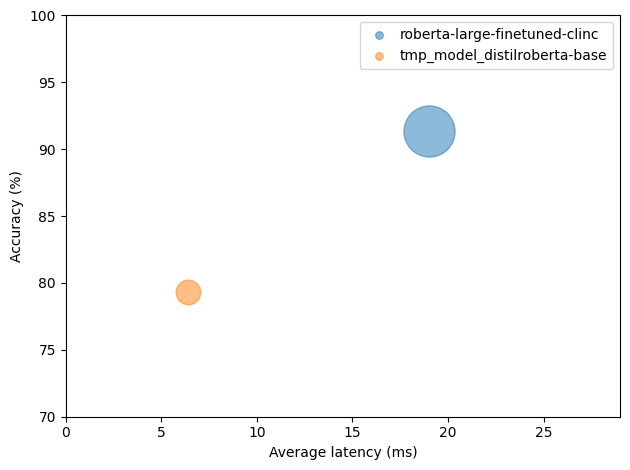

In [32]:
plot_metrics(performance_metrics)

# Knowledge Distillation: Student learning from Teacher

## HyperParameter Search Optimization using Optuna

In [33]:
import optuna

def hp_space(trial):
    
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
            "alpha": trial.suggest_float("alpha", 0, 1),
            "temperature": trial.suggest_int("temperature", 1, 20)}

In [34]:
!pip install -U ipywidgets # required for hyperparameter_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


**Note** Hyperparameter search is being carried out for limited number of trials to reduce the time for training for multiple trials. For better results the hyperparameter search may carried out for more trials to get better parameter values.

In [35]:
import warnings
warnings.filterwarnings("ignore")

student_finetune_trainer.model_init = student_init
best_hp_run = student_finetune_trainer.hyperparameter_search(n_trials=3,
                                                             direction='maximize', # to maximize accuracy
                                                             hp_space=hp_space)

2024-08-20 14:19:05,271	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
[I 2024-08-20 14:19:05,283] A new study created in memory with name: no-name-da8fc915-1fb6-4ea4-b529-fd97dc091307
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.193100,1.018789,0.727419
2,0.879000,0.730299,0.838387
3,0.688400,0.556358,0.880968
4,0.555500,0.439364,0.902581
5,0.464100,0.360985,0.919355
6,0.380000,0.306383,0.923871
7,0.338400,0.271482,0.936774
8,0.311700,0.253321,0.935484
9,0.301100,0.247207,0.936452


[I 2024-08-20 14:35:14,993] Trial 0 finished with value: 0.9364516129032258 and parameters: {'num_train_epochs': 9, 'alpha': 0.79523809929528, 'temperature': 5}. Best is trial 0 with value: 0.9364516129032258.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.980100,0.840824,0.723226
2,0.733500,0.617758,0.833871
3,0.594300,0.493718,0.872581
4,0.506600,0.419498,0.893548
5,0.456200,0.379672,0.902258
6,0.426500,0.366699,0.904839


[I 2024-08-20 14:46:02,541] Trial 1 finished with value: 0.9048387096774193 and parameters: {'num_train_epochs': 6, 'alpha': 0.7813229202331669, 'temperature': 6}. Best is trial 0 with value: 0.9364516129032258.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.578200,0.495634,0.714839
2,0.423200,0.354591,0.845161
3,0.333900,0.274398,0.888065
4,0.274900,0.223414,0.909677
5,0.237400,0.191148,0.916129
6,0.204600,0.170181,0.924194
7,0.190500,0.158735,0.928387
8,0.183000,0.155258,0.928387


[I 2024-08-20 15:00:25,152] Trial 2 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 8, 'alpha': 0.08007958981324292, 'temperature': 14}. Best is trial 0 with value: 0.9364516129032258.


In [36]:
best_hp_run.hyperparameters.items()

dict_items([('num_train_epochs', 9), ('alpha', 0.79523809929528), ('temperature', 5)])

**Best Parameter after running 3 Trials olny**: 
[('num_train_epochs', 10), ('alpha', 0.13763849494879565), ('temperature', 20)]

In [37]:
for key, value in best_hp_run.hyperparameters.items():
    setattr(student_training_args, key, value)

In [38]:
student_distil_ckpt = f"{student_model_name}-distil"
student_distil_save_dir = f"/kaggle/working/{student_distil_ckpt}"
student_training_args.output_dir = student_distil_save_dir

tmp_stu_model = (AutoModelForSequenceClassification
                 .from_pretrained(student_model_ckpt, config=student_config)).to(device)
student_finetune_trainer = DistillationTrainer(model=tmp_stu_model,
#                                                model_init=tmp_stu_model,
                                               teacher_model=teacher_model, 
                                               args=student_training_args,
                                               train_dataset=clinc_encoded['train'], 
                                               eval_dataset=clinc_encoded['validation'],
                                               compute_metrics=compute_metrics, 
                                               tokenizer=student_tokenizer)
student_finetune_trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.370500,2.884116,0.686452
2,2.232800,1.840746,0.811613
3,1.548100,1.254133,0.862258
4,1.103400,0.899694,0.898387
5,0.834400,0.698978,0.913226
6,0.622700,0.583352,0.923871
7,0.526400,0.515745,0.932258
8,0.473000,0.481037,0.937097
9,0.447700,0.469873,0.936774


TrainOutput(global_step=1431, training_loss=1.3477735726005293, metrics={'train_runtime': 968.5743, 'train_samples_per_second': 141.703, 'train_steps_per_second': 1.477, 'total_flos': 853236440350644.0, 'train_loss': 1.3477735726005293, 'epoch': 9.0})

In [39]:
# Save the model, tokenizer, and configuration
distil_student_model_save_name = f'model_distil_{student_model_name}'
distil_student_model_save_dir = f'/kaggle/working/model_distil_{student_model_name}'
student_finetune_trainer.save_model(distil_student_model_save_dir)  # Save model checkpoint to the specified directory
student_tokenizer.save_pretrained(distil_student_model_save_dir)


('/kaggle/working/model_distil_distilroberta-base/tokenizer_config.json',
 '/kaggle/working/model_distil_distilroberta-base/special_tokens_map.json',
 '/kaggle/working/model_distil_distilroberta-base/vocab.json',
 '/kaggle/working/model_distil_distilroberta-base/merges.txt',
 '/kaggle/working/model_distil_distilroberta-base/added_tokens.json',
 '/kaggle/working/model_distil_distilroberta-base/tokenizer.json')

In [40]:
distil_student_model_save_name

'model_distil_distilroberta-base'

Size of Model tmp_model_distil_distilroberta-base: 313.74 MB
avg latency: 5.963179290047265 +\- 0.2499508686887164 msec


Processing texts: 100%|██████████| 5500/5500 [00:00<00:00, 27398.45it/s]
getting preds and labels: 5500it [00:00, 26641.85it/s]


accuracy score: {'accuracy': 0.8634545454545455}
tmp_model_distil_distilroberta-base metrics: {'tmp_model_distil_distilroberta-base': {'model_size_MBs': 313.74, 'avg_latency_msec': 5.963179290047265, 'std_latency_msec': 0.2499508686887164, 'accuracy': 0.8634545454545455}}
                                     model_size_MBs  avg_latency_msec  \
roberta-large-finetuned-clinc               1356.34         19.017690   
tmp_model_distilroberta-base                 313.74          6.393363   
tmp_model_distil_distilroberta-base          313.74          5.963179   

                                     std_latency_msec  accuracy  
roberta-large-finetuned-clinc                0.553531  0.914000  
tmp_model_distilroberta-base                 0.937249  0.793091  
tmp_model_distil_distilroberta-base          0.249951  0.863455  


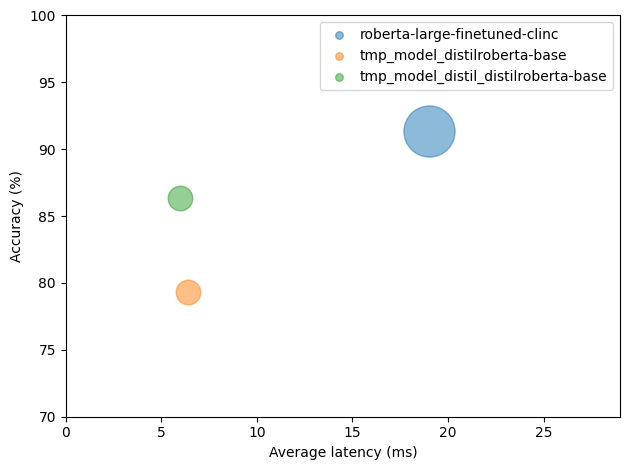

In [41]:
pipe_fine = pipeline('text-classification', 
                     model=distil_student_model_save_dir,
                     device=device)
pb = PerformanceBenchmark(pipe_fine, clinc_ds['test'], 'tmp_' + distil_student_model_save_name)
performance_metrics.update(pb.run_benchmark())

df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(df)
plot_metrics(performance_metrics)

# Model Quantization
* Model quantization is a powerful tool for optimizing machine learning models for deployment in **resource-constrained environments**.
* It does this by converting the model's weights and sometimes activations **from higher precision** (e.g., 32-bit floating-point, FP32) **to lower precision** (e.g., 16-bit floating-point, **FP16**, or 8-bit integers, **INT8**).


## Quantization Types
**Post-Training Quantization**:

    Applied after the model is fully trained.
    Converts weights and/or activations to lower precision without retraining.
    Subtypes:
        Dynamic Quantization: Activations are quantized dynamically during inference.
        Static Quantization: A calibration step is used to determine ranges for activations.

**Quantization-Aware Training**:

    Simulates quantization during training to account for any accuracy loss.
    Typically offers better accuracy than post training quantization, especially for complex models.

**Note** Quantization of the model is done on 'cpu'
Reference: 

In [42]:
from torch.quantization import quantize_dynamic
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

model_ckpt = distil_student_model_save_dir
quantized_model_name = f'distil-quantized'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt)
         .to("cpu")) # because the model has been quantized so device is set to cpu

quantized_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

In [43]:
quantized_model.device

device(type='cpu')

## Benchmark Quantized Model

Size of Model tmp_distil-quantized: 190.25 MB
avg latency: 12.025658840002507 +\- 0.5970127518989318 msec


Processing texts: 100%|██████████| 5500/5500 [00:00<00:00, 29056.27it/s]
getting preds and labels: 5500it [00:00, 26416.00it/s]


accuracy score: {'accuracy': 0.8581818181818182}
tmp_distil-quantized metrics: {'tmp_distil-quantized': {'model_size_MBs': 190.25, 'avg_latency_msec': 12.025658840002507, 'std_latency_msec': 0.5970127518989318, 'accuracy': 0.8581818181818182}}
                                     model_size_MBs  avg_latency_msec  \
roberta-large-finetuned-clinc               1356.34         19.017690   
tmp_model_distilroberta-base                 313.74          6.393363   
tmp_model_distil_distilroberta-base          313.74          5.963179   
tmp_distil-quantized                         190.25         12.025659   

                                     std_latency_msec  accuracy  
roberta-large-finetuned-clinc                0.553531  0.914000  
tmp_model_distilroberta-base                 0.937249  0.793091  
tmp_model_distil_distilroberta-base          0.249951  0.863455  
tmp_distil-quantized                         0.597013  0.858182  


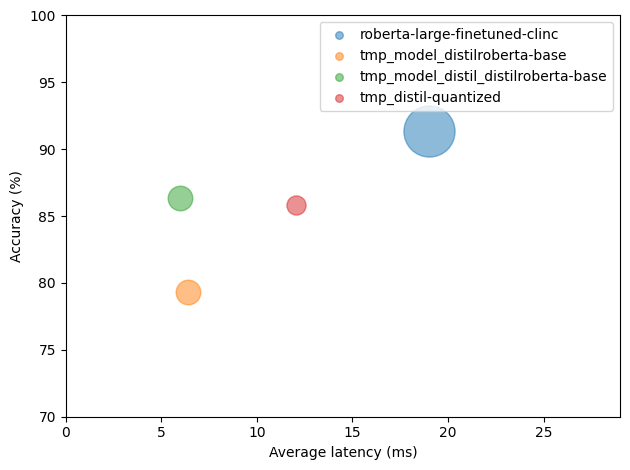

In [44]:
pipe_fine_quantized = pipeline('text-classification', 
                               model=quantized_model,
                               tokenizer=tokenizer,
                               device="cpu")
pb = PerformanceBenchmark(pipe_fine_quantized, clinc_ds['test'], 'tmp_' + quantized_model_name)
performance_metrics.update(pb.run_benchmark())

df = pd.DataFrame.from_dict(performance_metrics, orient='index')
print(df)
plot_metrics(performance_metrics)

**Note** Quantized model was validated on CPU

# ONNX for Model Inference Optimization
* ONNX (Open Neural Network Exchange)
* ONNX allows you to take a model trained in one environment and run it in many others
* standardized way to describe models
* Once a model is converted to ONNX format, it can be optimized for inference in various ways, such as reducing model size
* ONNX can be used with **ONNX Runtime**, an inference engine optimized for running ONNX models.

In [45]:
# import os
# from psutil import cpu_count
# os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}" # to utilize all available cores to maximize parallel processing.
# os.environ["OMP_WAIT_POLICY"] = "ACTIVE" # ensures that threads remain in an active, busy-wait state, can reduce latency

In [46]:
# from transformers.convert_graph_to_onnx import convert

# onnx_model_path = Path("/kaggle/working/onnx/model.onnx")
# convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
#         output=onnx_model_path, opset=13, pipeline_name="text-classification") # opset 13 is chosen because it is a stable, widely-supported version